In [361]:
#Imports
import matplotlib.pyplot as plt
import numpy as np 
import os
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.optim as optim
from tqdm.notebook import trange, tqdm

In [362]:
batch_size = 128

lr = 0.0002

n_epoch = 50

latent_size = 100

dataset_folder = "../dataset"

use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")
print(use_cuda)

True


In [363]:
class Discriminator(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.lin1 = nn.Linear(784, ch * 4)
        self.lin2 = nn.Linear(ch * 4, ch * 2)
        self.lin3 = nn.Linear(ch * 2, ch)
        self.lin4 = nn.Linear(ch, 1)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.dropout(F.leaky_relu(self.lin1(x), 0.2), 0.3)
        x = F.dropout(F.leaky_relu(self.lin2(x), 0.2), 0.3)
        x = F.dropout(F.leaky_relu(self.lin3(x), 0.2), 0.3)
        x = self.lin4(x)
        return F.sigmoid(x)
    
class Generator(nn.Module):
    def __init__(self, ch, latent_size):
        super().__init__()
        self.lin1 = nn.Linear(latent_size, ch)
        self.lin2 = nn.Linear(ch, ch * 2)
        self.lin3 = nn.Linear(ch * 2, ch * 4)
        self.lin4 = nn.Linear(ch * 4, 784)
    
    def forward(self, x):
        x = F.leaky_relu(self.lin1(x), 0.2)
        x = F.leaky_relu(self.lin2(x), 0.2)
        x = F.leaky_relu(self.lin3(x), 0.2)
        x = self.lin4(x)
        x = x.view(-1, 1, 28, 28)
        return F.tanh(x)

In [364]:
# MNIST dataset and dataloader
transform = transforms.Compose([
            transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = Datasets.MNIST(root=dataset_folder, train=True, transform=transform, download=True)
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True, num_workers=4)

test_set = Datasets.MNIST(root=dataset_folder, train=False, transform=transform, download=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [365]:
dataiter = iter(test_loader)
test_images = next(dataiter)[0]

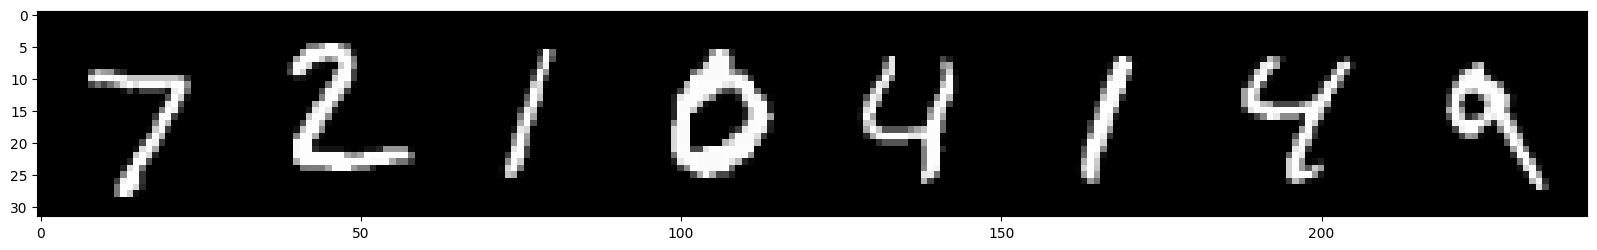

In [366]:
# Show data
plt.figure(figsize = (20,10))
out = vutils.make_grid(test_images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [367]:
# Create a Network

discriminator = Discriminator(256).to(device)
generator = Generator(256, latent_size).to(device)

d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)


d_loss_log = []
d_loss = 0

d_fresults = []
d_rresults = []

g_loss_log = []
g_loss = 0

g_images = list()

In [368]:
def loss_func(output, real=True):
    if real:
        return F.binary_cross_entropy_with_logits(output, torch.ones_like(output))
    else:
        return F.binary_cross_entropy_with_logits(output, torch.zeros_like(output))

In [370]:
pbar = trange(0, n_epoch, leave=False, desc="Epoch")
for i in pbar:
    pbar.set_postfix_str("D Loss: %.4f  G Loss: %.4f" % (d_loss/len(train_loader), g_loss/len(train_loader)))
    g_loss = 0
    d_loss = 0
    for j, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):
        images = data[0].to(device)
        
        bs = images.shape[0]
        
        #===== Generator =====
        latent_noise = torch.randn(bs, latent_size, 1, 1).to(device)
        fake_image = generator(latent_noise.view(-1, latent_size))
        d_result = discriminator(fake_image)
        g_train_loss = loss_func(d_result)
        
        g_loss_log.append(g_train_loss.item())
        g_loss += g_train_loss.item()
        
        generator.zero_grad()
        g_train_loss.backward()
        g_optimizer.step()
        
        #===== Discriminator =====
        d_real_result = discriminator(images)
        d_real_loss = loss_func(d_real_result)
        d_rresults.append(d_real_result.mean().item())
        
        latent_noise = torch.randn(bs, latent_size, 1, 1).to(device)
        d_fake_result = discriminator(generator(latent_noise.view(-1, latent_size)))
        d_fake_loss = loss_func(d_fake_result, False)
        d_fresults.append(d_fake_result.mean().item())
        
        d_train_loss = (d_real_loss + d_fake_loss)
        
        d_loss_log.append(d_train_loss.item())
        d_loss += d_train_loss.item()
        
        discriminator.zero_grad()
        d_train_loss.backward()
        d_optimizer.step()
    g_images.append(fake_image)


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

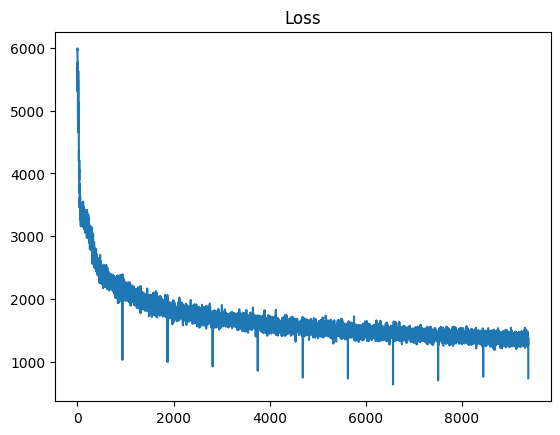

In [237]:
_ = plt.plot(loss_log)
_ = plt.title("Loss")

In [ ]:
# autoencoder = VariationalAutoEncoder(channels=1, ch=16, latent_size=128).to(device)

# optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

# autoencoder.load_state_dict(torch.load("./lab1.pth", weights_only=True))
# autoencoder.eval()

In [373]:
# plt.figure(figsize = (20,10))
noise = torch.rand((64, latent_size)).to(device)
# out = vutils.make_grid(noise.detach().cpu().view(64, 1, 28, 28)[0:8], normalize=True)
# _ = plt.imshow(out.numpy().transpose((1, 2, 0)))

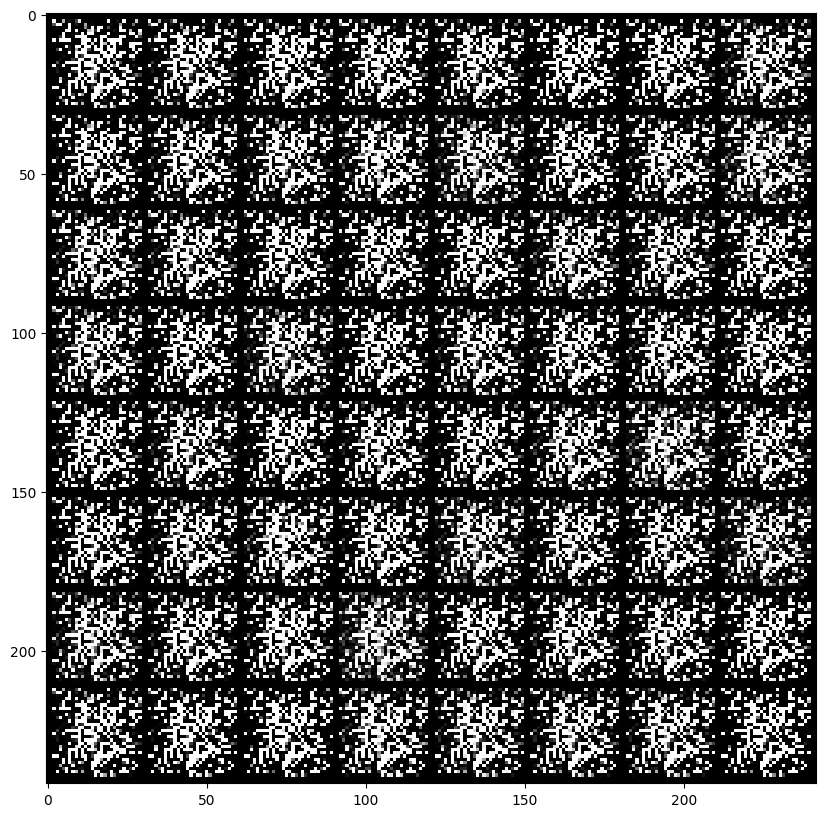

In [384]:
plt.figure(figsize = (20,10))
latent_noise = torch.randn(64, latent_size, 1, 1).to(device)
noise = torch.rand((64, latent_size)).to(device)
recon_data = generator(latent_noise.view(-1, latent_size))
out = vutils.make_grid(recon_data.detach().cpu().view(64, 1, 28, 28), normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
latent_noise = torch.randn(64, latent_size, 1, 1).to(device)
fake_image = generator(latent_noise.view(-1, latent_size))

In [ ]:
torch.save(autoencoder.state_dict(), "./lab1.pth")